# Import Libraries

In [1]:
import random
random.seed(18303901)
seed = 18303901
import inspect
from itertools import cycle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBClassifier
import torch.cuda as cuda
gpu = cuda.is_available()
print(f'GPU is available: {gpu}')

GPU is available: True


# Import Dataset

In [2]:
df = pd.read_csv('musicData.csv').set_index('instance_id')
df

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
instance_id,,,,,,,,,,,,,,,,,
32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop


# Data Cleaning

In [3]:
df[df.isnull().any(axis=1)]

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
instance_id,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There're 5 rows with all NaN values. Dropping.

In [4]:
df.dropna(axis=0, how='any', inplace=True)

Tempo has missing values. Replacing with mean. 

In [5]:
average_tempo = df['tempo'][df['tempo'] != '?'].astype('float64').mean()
df['tempo'].replace({'?':average_tempo}, inplace=True)
df['tempo'] = df['tempo'].astype('float64')

obtained_date, artist_name, and track_name contain no actual information for prediction, dropping. 

In [6]:
df.drop(columns=['obtained_date', 'artist_name', 'track_name'], inplace=True)

duration_ms contains invalid values -1. Replacing with mean.

In [7]:
average_duration = df['duration_ms'][df['duration_ms'] != -1].mean()
df['duration_ms'].replace({-1:average_duration}, inplace=True)

mode and key are related to each other. For example, we say a song is in C major, but don't use the key or the mode individually. Let's combine them and then transform them into dummies. 

In [8]:
# All the distinct combinations of key and mode, and their counts
# This line is from https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
df.groupby(['key','mode']).size().reset_index().rename(columns={0:'count'})

,key,mode,count
0,A,Major,2950
1,A,Minor,1875
2,A#,Major,1593
3,A#,Minor,1763
4,B,Major,1662
5,B,Minor,2127
6,C,Major,4307
7,C,Minor,1215
8,C#,Major,3910
9,C#,Minor,1495


In [9]:
# Combine and make dummy
df['key_mode'] = df['key'] + '_' + df['mode']
df.drop(columns=['key', 'mode'], inplace=True)
df = pd.get_dummies(df, columns=['key_mode'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 50000 entries, 32894.0 to 63470.0
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         50000 non-null  float64
 1   acousticness       50000 non-null  float64
 2   danceability       50000 non-null  float64
 3   duration_ms        50000 non-null  float64
 4   energy             50000 non-null  float64
 5   instrumentalness   50000 non-null  float64
 6   liveness           50000 non-null  float64
 7   loudness           50000 non-null  float64
 8   speechiness        50000 non-null  float64
 9   tempo              50000 non-null  float64
 10  valence            50000 non-null  float64
 11  music_genre        50000 non-null  object 
 12  key_mode_A#_Major  50000 non-null  uint8  
 13  key_mode_A#_Minor  50000 non-null  uint8  
 14  key_mode_A_Major   50000 non-null  uint8  
 15  key_mode_A_Minor   50000 non-null  uint8  
 16  key_mode_B_M

Here we have columns 0 through 10 our numerical features, column 11 is our target variable, and columns 12 through 35 dummies for key_mode. 

# Split Features and Target

Our target variable is represented in strings. Let's transform them into numerical for easier handling. 

In [11]:
translation_dict = pd.Series(index=df['music_genre'].value_counts().index, data=range(10)).to_dict()
translation_back_dict = {v:k for k, v in translation_dict.items()}

In [12]:
X = df.drop(columns=['music_genre'], inplace=False)
y = df['music_genre'].map(translation_dict)

# Metrics

In [13]:
# metrics must accept parameters y_true and y_pred
metrics = [f1_score, accuracy_score, precision_score, recall_score]
# Create a DataFrame to store the metrics
metric_frame = pd.DataFrame(dtype='float64')

# Custom Function

In [14]:
def evaluate(classifier, metrics, metric_frame, X, y, classifier_name=None, classifier_params={}, param_grid={}):
    
    name = classifier_name if classifier_name else classifier.__name__
    
    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(classifier(**classifier_params), param_grid, n_jobs=-1)
    grid.fit(X, y)
    if grid.best_params_:
        print(grid.best_params_)
    
    # Split training and testing, with equal class counts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)
    
    # Train the model on all features
    clf = classifier(**classifier_params, **grid.best_params_)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    
    # Code below for plotting is from
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    # Binarize target
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    # y_onehot_test.shape  # (n_samples, n_classes)
    
    # store the fpr, tpr, and roc_auc for micro averaging strategy
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the micro average ROC
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    # Plot the ROC for each class
    cmap = plt.get_cmap('tab10')  # type: matplotlib.colors.ListedColormap
    colors = cycle(cmap.colors)  # type: list
    for class_id, color in zip(range(y_onehot_test.shape[1]), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {translation_back_dict[class_id]}",
            color=color,
            ax=ax,
        )

    # Save and show the plot
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Extension of Receiver Operating Characteristic to One-vs-Rest multiclass\n{name}")
    plt.legend()
    plt.savefig(f'{name}.png')
    plt.show()
    
    # End of Reference
        
    # Calculate metrics
    metric_frame.at[name, 'AUC_micro'] = roc_auc["micro"]
    for metric in metrics:
        if 'average' in list(inspect.signature(metric).parameters.keys()):
            metric_frame.at[name, metric.__name__] = metric(y_true=y_test, y_pred=y_pred, average='micro')
        else:
            metric_frame.at[name, metric.__name__] = metric(y_true=y_test, y_pred=y_pred)
    
    # return the trained classifier for future use
    return clf

# Logistic Regression

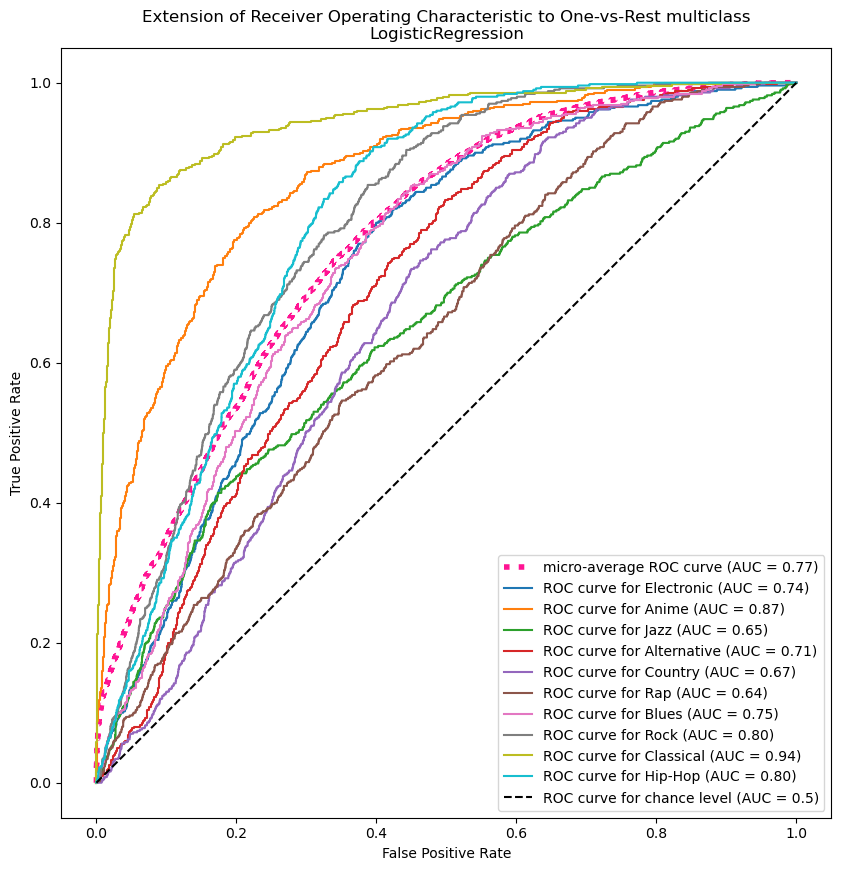

LogisticRegression(max_iter=10000, multi_class='ovr', n_jobs=-1,
                   random_state=18303901)

In [15]:
evaluate(LogisticRegression, metrics, metric_frame, X, y, None, 
         classifier_params={'multi_class':'ovr', 'random_state':seed, 'n_jobs':-1, 'max_iter':10000}, param_grid={})

# XGBoost

In [16]:
gpu_id = 0 if gpu else -1
tree_method = 'gpu_hist' if gpu else 'auto'

In [17]:
param_grid_xgb = {
    'n_estimators':[10, 100, 1000],
    'max_depth':[1, 10, 100, None]
}

C:\Users\Public\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 1, 'n_estimators': 1000}


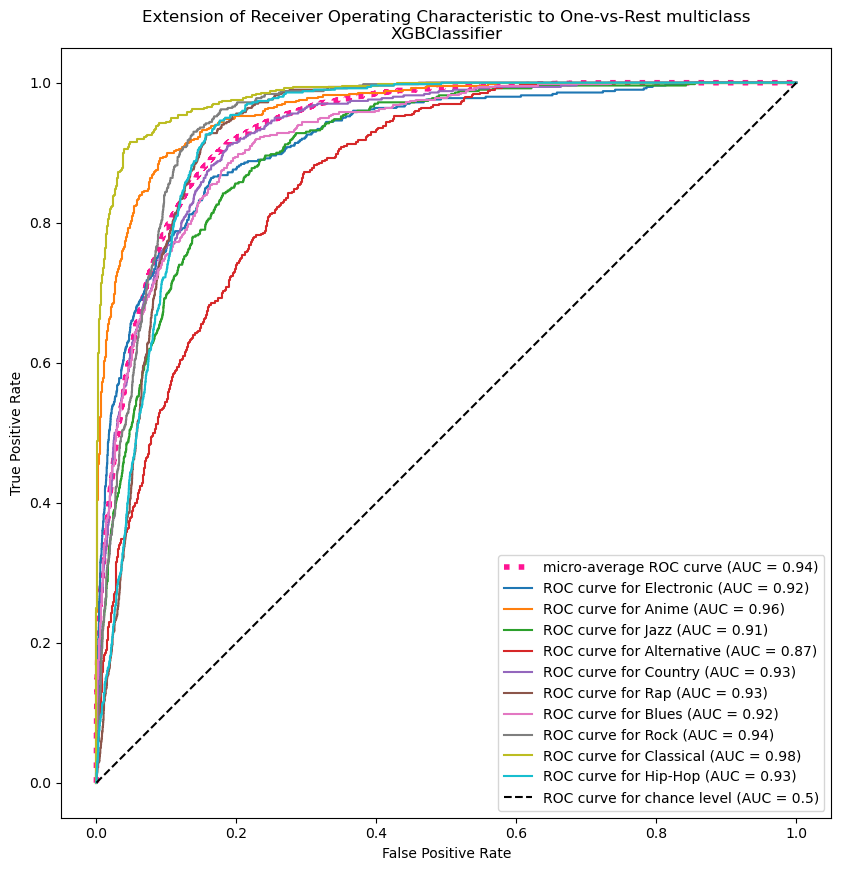

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [18]:
evaluate(XGBClassifier, metrics, metric_frame, X, y, None, 
         classifier_params={'n_jobs':-1, 'random_state':seed, 'gpu_id':gpu_id, 'tree_method':tree_method}, param_grid=param_grid_xgb)

# Random Forest

In [19]:
param_grid_rf = {
    'n_estimators':[10, 100, 1000],
    'max_depth':[1, 10, 100, None]
}

C:\Users\Public\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 10, 'n_estimators': 1000}


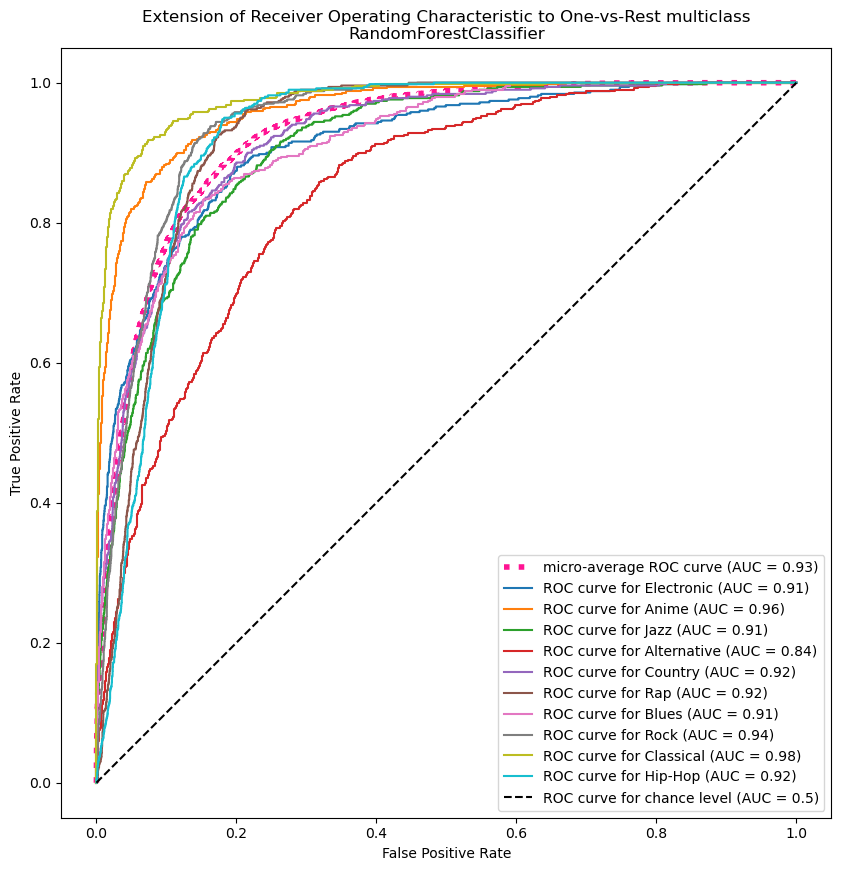

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1,
                       random_state=18303901)

In [20]:
evaluate(RandomForestClassifier, metrics, metric_frame, X, y, None, 
         classifier_params={'n_jobs':-1, 'random_state':seed}, param_grid=param_grid_rf)

# AdaBoost

In [21]:
param_grid_adb = {
    'estimator':[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=10),
        DecisionTreeClassifier(max_depth=None)
    ],
    'n_estimators':[10, 50, 100],
    'learning_rate':[0.1, 1.0, 10]
}

{'estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 10, 'n_estimators': 100}


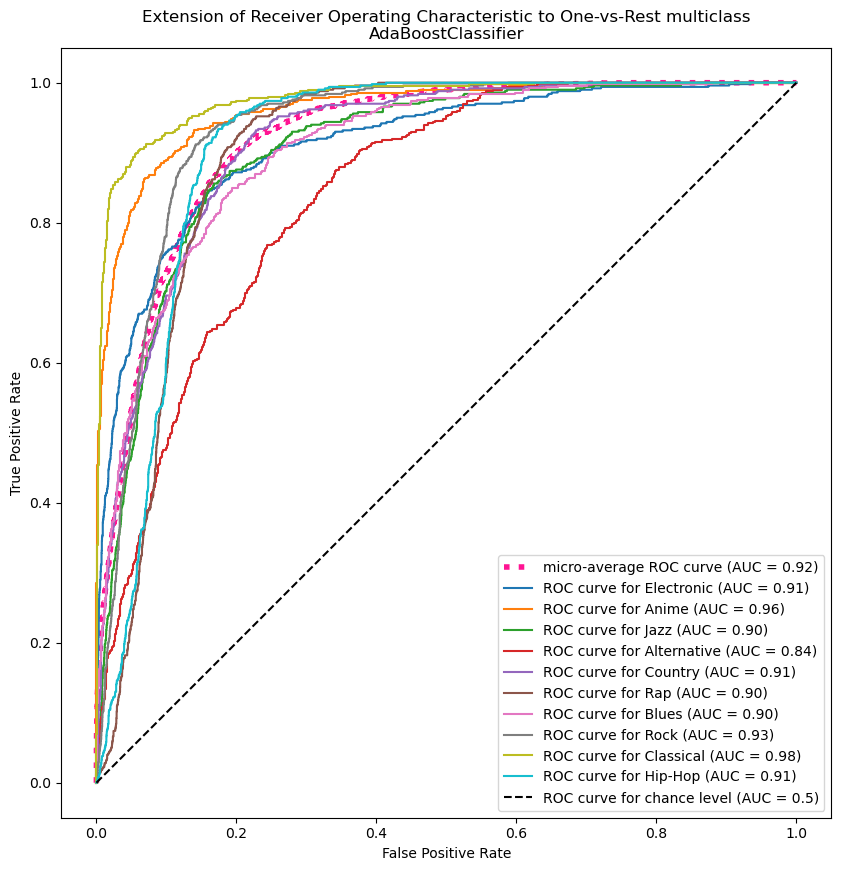

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=10, n_estimators=100, random_state=18303901)

In [22]:
evaluate(AdaBoostClassifier, metrics, metric_frame, X, y, None, 
         classifier_params={'random_state':seed}, param_grid=param_grid_adb)

# XGBoost with PCA

In [23]:
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X)

{'max_depth': 10, 'n_estimators': 10}


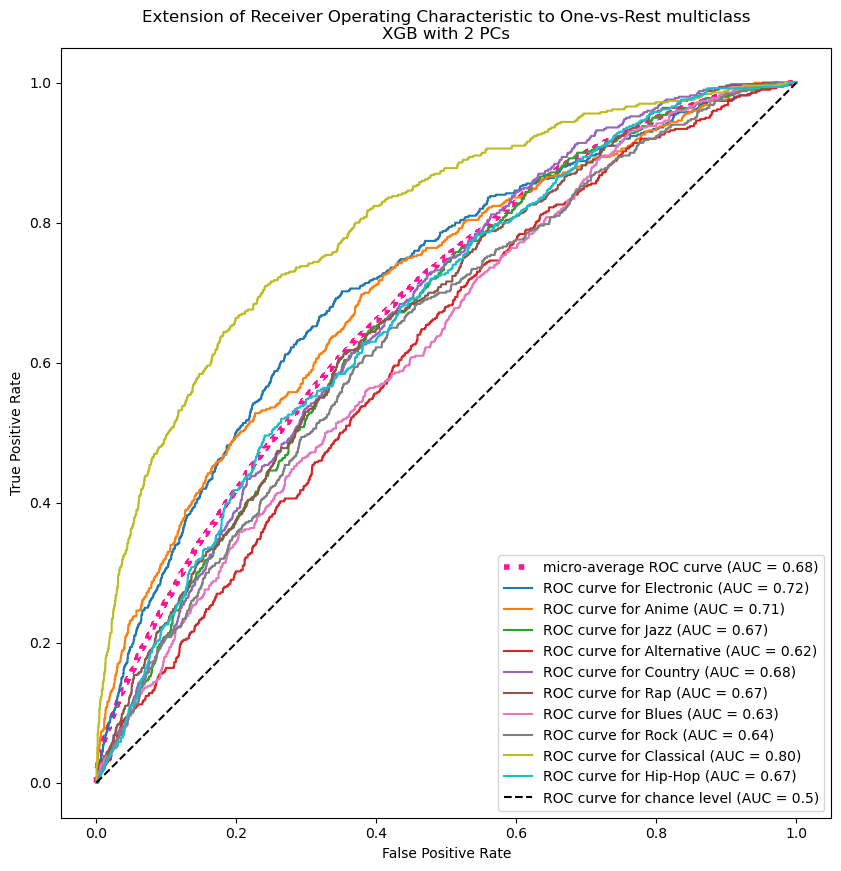

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [24]:
evaluate(XGBClassifier, metrics, metric_frame, X_pca, y, 'XGB with 2 PCs', 
         classifier_params={'n_jobs':-1, 'random_state':seed, 'gpu_id':gpu_id, 'tree_method':tree_method}, param_grid=param_grid_xgb)

# Metrics for Models

In [25]:
metric_frame

,AUC_micro,f1_score,accuracy_score,precision_score,recall_score
LogisticRegression,0.773492,0.2796,0.2796,0.2796,0.2796
XGBClassifier,0.935002,0.5768,0.5768,0.5768,0.5768
RandomForestClassifier,0.925246,0.5534,0.5534,0.5534,0.5534
AdaBoostClassifier,0.920657,0.5190,0.5190,0.5190,0.5190
XGB with 2 PCs,0.684540,0.2078,0.2078,0.2078,0.2078


# Clustering

## PCA

In [26]:
df_numerical = df.select_dtypes(include='float64')

In [27]:
# Normalize the dataset
df_numerical = (df_numerical-df_numerical.mean())/df_numerical.std()

In [28]:
cov_mat = np.cov(df_numerical.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
print(eigenvalues)

[3.70493226 1.34611637 0.11074018 0.25680731 0.46032667 0.5960226
 0.72885608 0.81914691 1.05368136 0.97588214 0.94748813]


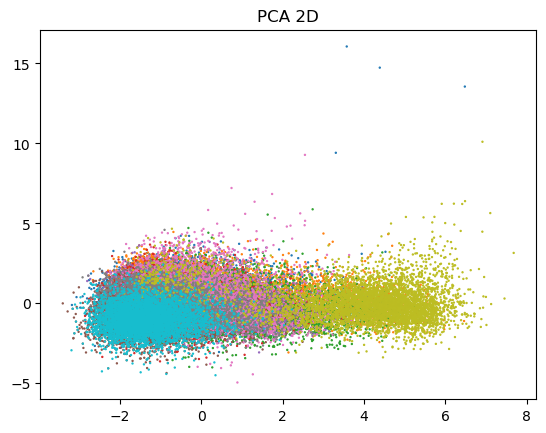

In [29]:
pca = PCA(n_components=2, random_state=seed)
pca_df = pd.DataFrame(pca.fit_transform(df_numerical))
plt.scatter(pca_df.loc[:, 0], pca_df.loc[:, 1], s=.5, c=y, cmap='tab10')
plt.title('PCA 2D')
plt.savefig('pca_2d.png')
plt.show()

In [30]:
print('Explained Variances:', pca.explained_variance_)
print('Explained Total Variance Ratio:', pca.explained_variance_ratio_.sum())

Explained Variances: [3.70493226 1.34611637]
Explained Total Variance Ratio: 0.45918623888777443


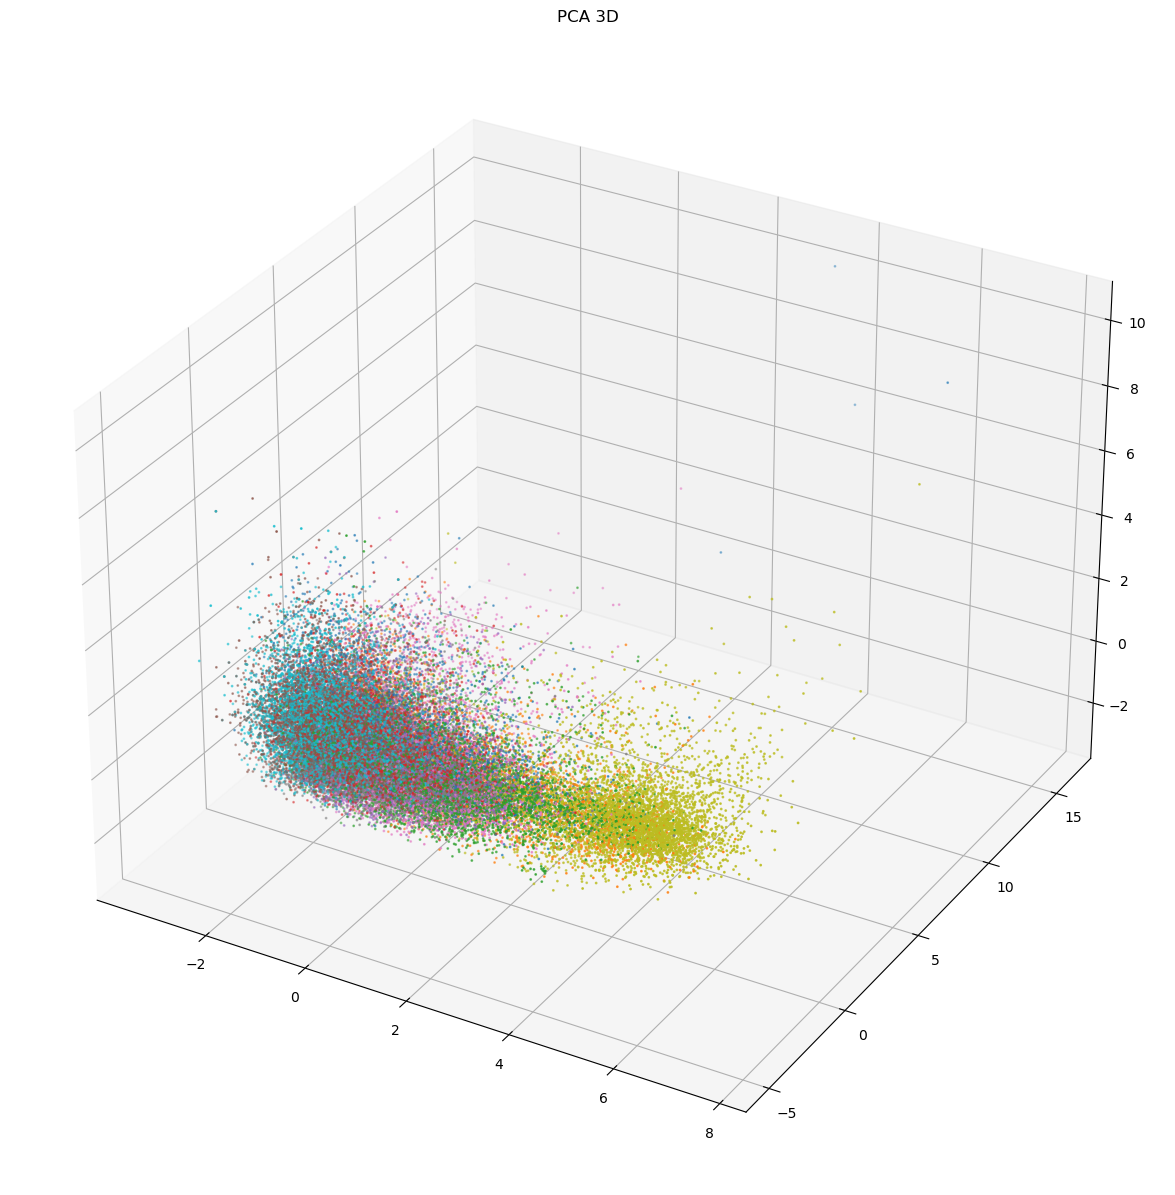

In [31]:
pca = PCA(n_components=3, random_state=seed)
pca_df = pd.DataFrame(pca.fit_transform(df_numerical))
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
ax.scatter3D(pca_df.loc[:, 0], pca_df.loc[:, 1], pca_df.loc[:, 2], s=1, c=y, cmap='tab10')
ax.set_title('PCA 3D')
plt.savefig('pca_3d.png')
plt.show()

In [32]:
print('Explained Variances:', pca.explained_variance_)
print('Explained Total Variance Ratio:', pca.explained_variance_ratio_.sum())

Explained Variances: [3.70493226 1.34611637 1.05368136]
Explained Total Variance Ratio: 0.5549754536250777


## t-SNE

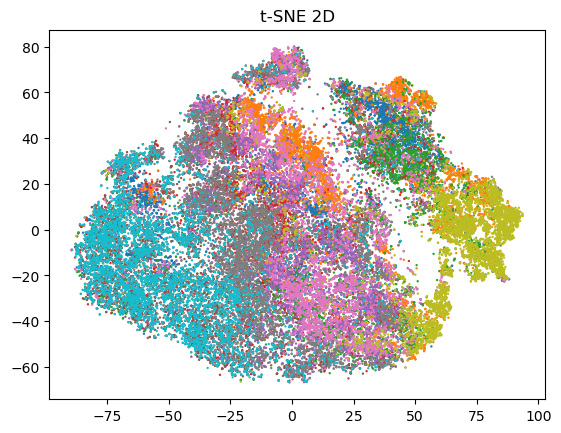

In [33]:
tsne = TSNE(n_components=2, perplexity=100, random_state=seed)
tsne_df = pd.DataFrame(tsne.fit_transform(df_numerical))
plt.scatter(tsne_df.loc[:, 0], tsne_df.loc[:, 1], s=.5, c=y, cmap='tab10')
plt.title('t-SNE 2D')
plt.savefig('t-SNE_2D.png')
plt.show()

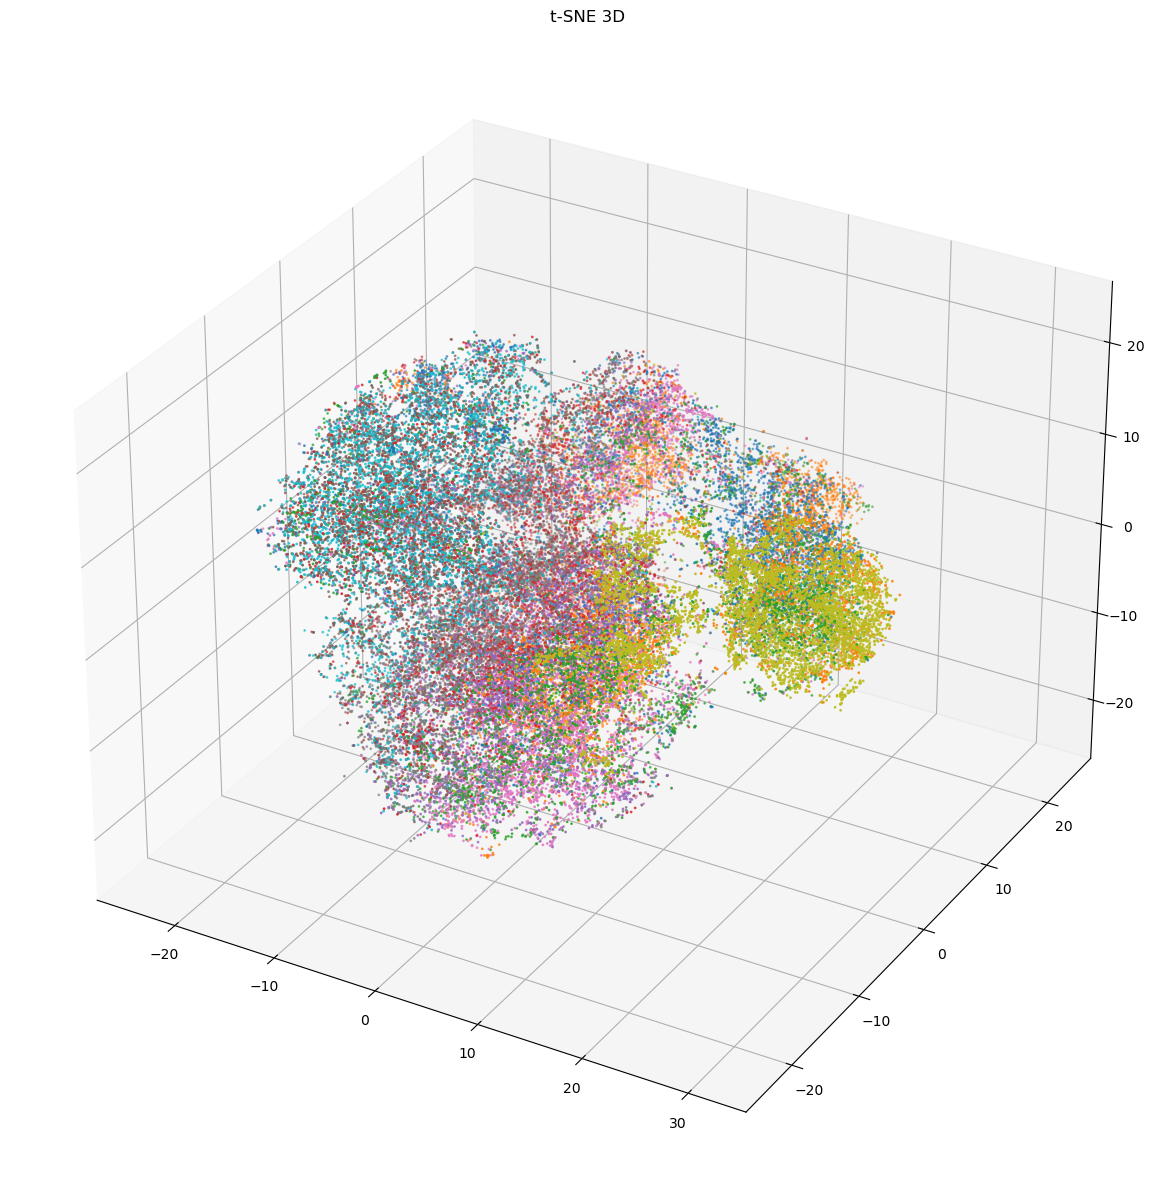

In [34]:
tsne = TSNE(n_components=3, perplexity=100, random_state=seed)
tsne_df = pd.DataFrame(tsne.fit_transform(df_numerical))
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection="3d")
ax.scatter3D(tsne_df.loc[:, 0], tsne_df.loc[:, 1], tsne_df.loc[:, 2], s=1, c=y, cmap='tab10')
ax.set_title('t-SNE 3D')
plt.savefig('t-SNE_3d.png')
plt.show()

## KMeans without labels

In [35]:
silhouettes = pd.Series(index=np.arange(2, 20), dtype='float64')

In [36]:
for k in silhouettes.index:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=seed)
    labels = kmeans.fit_predict(df_numerical)
    silhouettes[k] = silhouette_score(df_numerical, labels)

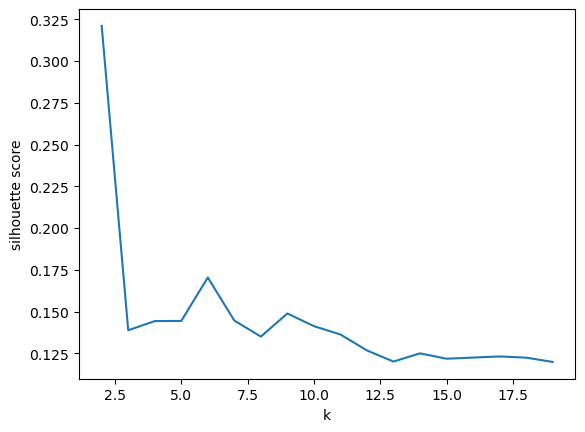

In [37]:
plt.plot(silhouettes)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.savefig('silhouette_vs_k.png')
plt.show()

In [38]:
silhouettes.index[silhouettes.argmax()]

2

2 clusters has the highest silhouette score, which is the minimum number of clusters possible. This means the points are too close together, and there's no meaningful clustering possible. 